In [1]:
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import friedmanchisquare, kruskal, rankdata
from scikit_posthocs import posthoc_dunn
import scikit_posthocs as sp

In [2]:
files = [
    ("balanced_2DCNN_metrics_output.csv", "2DCNN"),
    ("balanced_AE_metrics_output.csv", "AE"),
    ("balanced_bayes_metrics_output.csv", "Bayes"),
    ("balanced_dt_metrics_output.csv", "DT"),
    ("balanced_knn_metrics_output.csv", "KNN"),
    ("balanced_lr_metrics_output.csv", "LR"),
    ("balanced_mlp_metrics_output.csv", "MLP"),
    ("balanced_rf_metrics_output.csv", "RF"),
    ("balanced_svm_metrics_output.csv", "SVM"),
]

In [3]:
selected_metric = "Accuracy" 
metric_data = {
    model_name: pl.read_csv(file, separator=";")[selected_metric].to_list()
    for file, model_name in files
}

In [4]:
# Teste de Friedman
def friedman_test(data):
    model_values = list(data.values())
    stat, p_value = friedmanchisquare(*model_values)
    return stat, p_value

# Teste de Kruskal-Wallis
def kruskal_test(data):
    model_values = list(data.values())
    stat, p_value = kruskal(*model_values)
    return stat, p_value

# Teste Pós-Hoc de Dunn
def dunn_posthoc(metric_data, p_adjust):
    all_data = pd.concat(
    [pd.DataFrame({"Model": model, selected_metric: values}) for model, values in metric_data.items()],
    ignore_index=True,
)
    return posthoc_dunn(all_data, val_col=selected_metric, group_col="Model", p_adjust=p_adjust)

def calcular_ranks_do_csv(file_path):
    df = pd.read_csv(file_path, delimiter=";")
    if selected_metric not in df.columns:
        raise ValueError(f"A métrica {selected_metric} não foi encontrada nas colunas do CSV.")
    df['Rank'] = rankdata(-df[selected_metric])
    return df[['Algorithm', selected_metric, 'Rank']].sort_values(by='Rank', ascending=True)

def compararPorAlgoritmo(algorithm):
    return df_all[df_all['Algorithm 1'] == algorithm]

In [5]:
file_path = '_balanced_mean_metrics_output.csv'
calcular_ranks_do_csv(file_path)

,Algorithm,Accuracy,Rank
3,rf,0.994975,1.0
5,DT,0.994919,2.0
0,KNN,0.992121,3.0
7,MLP,0.991812,4.0
2,SVM,0.991085,5.0
8,2DCNN,0.987457,6.0
6,AE,0.981966,7.0
4,Bayes,0.981807,8.0
1,LR,0.981202,9.0


In [6]:
stat, p_value = kruskal_test(metric_data)
print(f"Teste de Kruskal-Wallis para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Kruskal-Wallis para Accuracy
Estatística de teste: 86.88624267176073
P-valor: 1.9898646564574323e-15


In [7]:
stat, p_value = friedman_test(metric_data)
print(f"Teste de Friedman para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Friedman para Accuracy
Estatística de teste: 79.12
P-valor: 7.349488731808664e-14


In [8]:
if p_value < 0.05:
    print(f"Há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")
    posthoc_results = dunn_posthoc(metric_data, p_adjust="fdr_bh")
    print("Resultados do teste pós-hoc de Dunn:")
    print(posthoc_results)
else:
    print(f"Não há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")


Há diferenças estatisticamente significativas entre os modelos para 'Accuracy'.
Resultados do teste pós-hoc de Dunn:
          2DCNN            AE         Bayes            DT       KNN  \
2DCNN  1.000000  3.299160e-01  1.644573e-01  1.682464e-03  0.020448   
AE     0.329916  1.000000e+00  6.686324e-01  2.596475e-05  0.000760   
Bayes  0.164457  6.686324e-01  1.000000e+00  3.608169e-06  0.000143   
DT     0.001682  2.596475e-05  3.608169e-06  1.000000e+00  0.415026   
KNN    0.020448  7.602612e-04  1.430266e-04  4.150264e-01  1.000000   
LR     0.023480  2.195822e-01  4.150264e-01  5.372513e-08  0.000003   
MLP    0.125104  1.063915e-02  2.740691e-03  1.251039e-01  0.415026   
RF     0.000094  7.187506e-07  8.175726e-08  4.330281e-01  0.126990   
SVM    0.415026  8.012045e-02  2.834136e-02  2.009898e-02  0.125104   

                 LR       MLP            RF       SVM  
2DCNN  2.348031e-02  0.125104  9.425080e-05  0.415026  
AE     2.195822e-01  0.010639  7.187506e-07  0.080120  
Baye

In [9]:
# Definir o nível de significância
alpha = 0.05

# Obter todos os pares possíveis (incluindo duplicações)
all_pairs = np.indices(posthoc_results.shape)  # Inclui todos os pares (toda a matriz)
all_results = []

# Gerar uma lista legível com todos os pares
for i, j in zip(all_pairs[0].flatten(), all_pairs[1].flatten()):
    model_i = posthoc_results.index[i]
    model_j = posthoc_results.columns[j]
    p_value = posthoc_results.iloc[i, j]
    significance = 'Significativo' if p_value < alpha else 'Não Significativo'
    all_results.append((model_i, model_j, p_value, significance))

# Criar um DataFrame para exibir os resultados como tabela
df_all = pd.DataFrame(all_results, columns=['Algorithm 1', 'Algorithm 2', 'p-value', 'Significância'])

# Exibir a tabela
print("Pares com resultados e significância")
print(df_all)


Pares com resultados e significância
   Algorithm 1 Algorithm 2   p-value      Significância
0        2DCNN       2DCNN  1.000000  Não Significativo
1        2DCNN          AE  0.329916  Não Significativo
2        2DCNN       Bayes  0.164457  Não Significativo
3        2DCNN          DT  0.001682      Significativo
4        2DCNN         KNN  0.020448      Significativo
..         ...         ...       ...                ...
76         SVM         KNN  0.125104  Não Significativo
77         SVM          LR  0.002165      Significativo
78         SVM         MLP  0.415026  Não Significativo
79         SVM          RF  0.001876      Significativo
80         SVM         SVM  1.000000  Não Significativo

[81 rows x 4 columns]


In [10]:
compararPorAlgoritmo('DT')

,Algorithm 1,Algorithm 2,p-value,Significância
27,DT,2DCNN,1.682464e-03,Significativo
28,DT,AE,2.596475e-05,Significativo
29,DT,Bayes,3.608169e-06,Significativo
30,DT,DT,1.000000e+00,Não Significativo
31,DT,KNN,4.150264e-01,Não Significativo
32,DT,LR,5.372513e-08,Significativo
33,DT,MLP,1.251039e-01,Não Significativo
34,DT,RF,4.330281e-01,Não Significativo
35,DT,SVM,2.009898e-02,Significativo


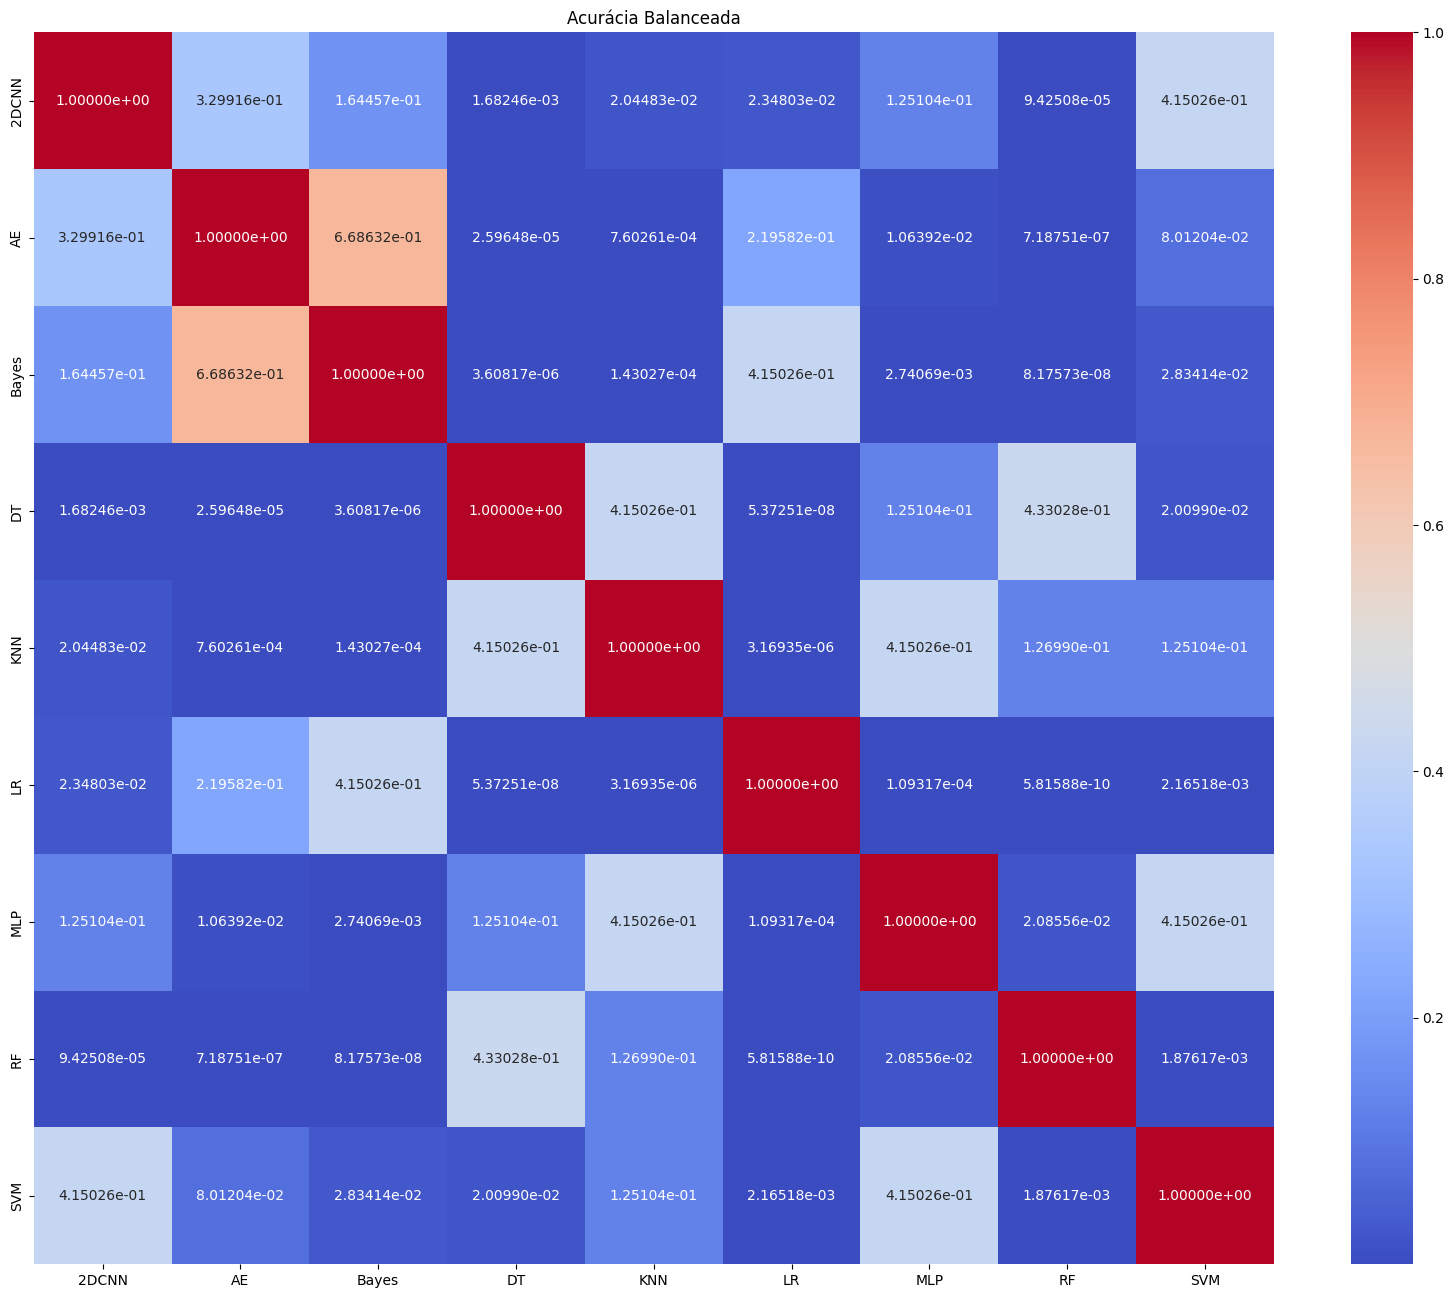

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o formato como notação científica
plt.figure(figsize=(20, 16))
sns.heatmap(posthoc_results, annot=True, fmt=".5e", cmap="coolwarm", cbar=True)  # .2e para notação científica
plt.title(f"Acurácia Balanceada")

# Salvando a figura como um PDF
plt.savefig(f"{selected_metric}_heat_map.pdf", format="pdf")

# Mostrando o gráfico
plt.show()


In [12]:
selected_metric = "F1-score" 
metric_data = {
    model_name: pl.read_csv(file, separator=";")[selected_metric].to_list()
    for file, model_name in files
}

In [13]:
file_path = '_balanced_mean_metrics_output.csv'
calcular_ranks_do_csv(file_path)

,Algorithm,F1-score,Rank
3,rf,0.996999,1.0
5,DT,0.996966,2.0
0,KNN,0.995288,3.0
7,MLP,0.995102,4.0
2,SVM,0.994666,5.0
8,2DCNN,0.992485,6.0
6,AE,0.989231,7.0
4,Bayes,0.989166,8.0
1,LR,0.988763,9.0


In [14]:
stat, p_value = kruskal_test(metric_data)
print(f"Teste de Kruskal-Wallis para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Kruskal-Wallis para F1-score
Estatística de teste: 86.86836087031683
P-valor: 2.0065253807718317e-15


In [15]:
stat, p_value = friedman_test(metric_data)
print(f"Teste de Friedman para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Friedman para F1-score
Estatística de teste: 79.12
P-valor: 7.349488731808664e-14


In [16]:
if p_value < 0.05:
    print(f"Há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")
    posthoc_results = dunn_posthoc(metric_data, p_adjust="fdr_bh")
    print("Resultados do teste pós-hoc de Dunn:")
    print(posthoc_results)
else:
    print(f"Não há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")


Há diferenças estatisticamente significativas entre os modelos para 'F1-score'.
Resultados do teste pós-hoc de Dunn:
          2DCNN            AE         Bayes            DT       KNN  \
2DCNN  1.000000  3.299771e-01  1.645088e-01  1.684678e-03  0.020464   
AE     0.329977  1.000000e+00  6.686645e-01  2.602291e-05  0.000761   
Bayes  0.164509  6.686645e-01  1.000000e+00  3.617776e-06  0.000143   
DT     0.001685  2.602291e-05  3.617776e-06  1.000000e+00  0.415078   
KNN    0.020464  7.613916e-04  1.432887e-04  4.150780e-01  1.000000   
LR     0.023497  2.196388e-01  4.150780e-01  5.392532e-08  0.000003   
MLP    0.125151  1.064881e-02  2.743921e-03  1.251507e-01  0.415078   
RF     0.000094  7.209543e-07  8.204832e-08  4.330773e-01  0.127036   
SVM    0.415078  8.015853e-02  2.836044e-02  2.011459e-02  0.125151   

                 LR       MLP            RF       SVM  
2DCNN  2.349715e-02  0.125151  9.443539e-05  0.415078  
AE     2.196388e-01  0.010649  7.209543e-07  0.080159  
Baye

In [17]:
# Definir o nível de significância
alpha = 0.05

# Obter todos os pares possíveis (incluindo duplicações)
all_pairs = np.indices(posthoc_results.shape)  # Inclui todos os pares (toda a matriz)
all_results = []

# Gerar uma lista legível com todos os pares
for i, j in zip(all_pairs[0].flatten(), all_pairs[1].flatten()):
    model_i = posthoc_results.index[i]
    model_j = posthoc_results.columns[j]
    p_value = posthoc_results.iloc[i, j]
    significance = 'Significativo' if p_value < alpha else 'Não Significativo'
    all_results.append((model_i, model_j, p_value, significance))

# Criar um DataFrame para exibir os resultados como tabela
df_all = pd.DataFrame(all_results, columns=['Algorithm 1', 'Algorithm 2', 'p-value', 'Significância'])

# Exibir a tabela
print("Pares com resultados e significância")
print(df_all)


Pares com resultados e significância
   Algorithm 1 Algorithm 2   p-value      Significância
0        2DCNN       2DCNN  1.000000  Não Significativo
1        2DCNN          AE  0.329977  Não Significativo
2        2DCNN       Bayes  0.164509  Não Significativo
3        2DCNN          DT  0.001685      Significativo
4        2DCNN         KNN  0.020464      Significativo
..         ...         ...       ...                ...
76         SVM         KNN  0.125151  Não Significativo
77         SVM          LR  0.002168      Significativo
78         SVM         MLP  0.415078  Não Significativo
79         SVM          RF  0.001879      Significativo
80         SVM         SVM  1.000000  Não Significativo

[81 rows x 4 columns]


In [18]:
compararPorAlgoritmo('RF')

,Algorithm 1,Algorithm 2,p-value,Significância
63,RF,2DCNN,9.443539e-05,Significativo
64,RF,AE,7.209543e-07,Significativo
65,RF,Bayes,8.204832e-08,Significativo
66,RF,DT,4.330773e-01,Não Significativo
67,RF,KNN,1.270359e-01,Não Significativo
68,RF,LR,5.843681e-10,Significativo
69,RF,MLP,2.087123e-02,Significativo
70,RF,RF,1.000000e+00,Não Significativo
71,RF,SVM,1.878569e-03,Significativo


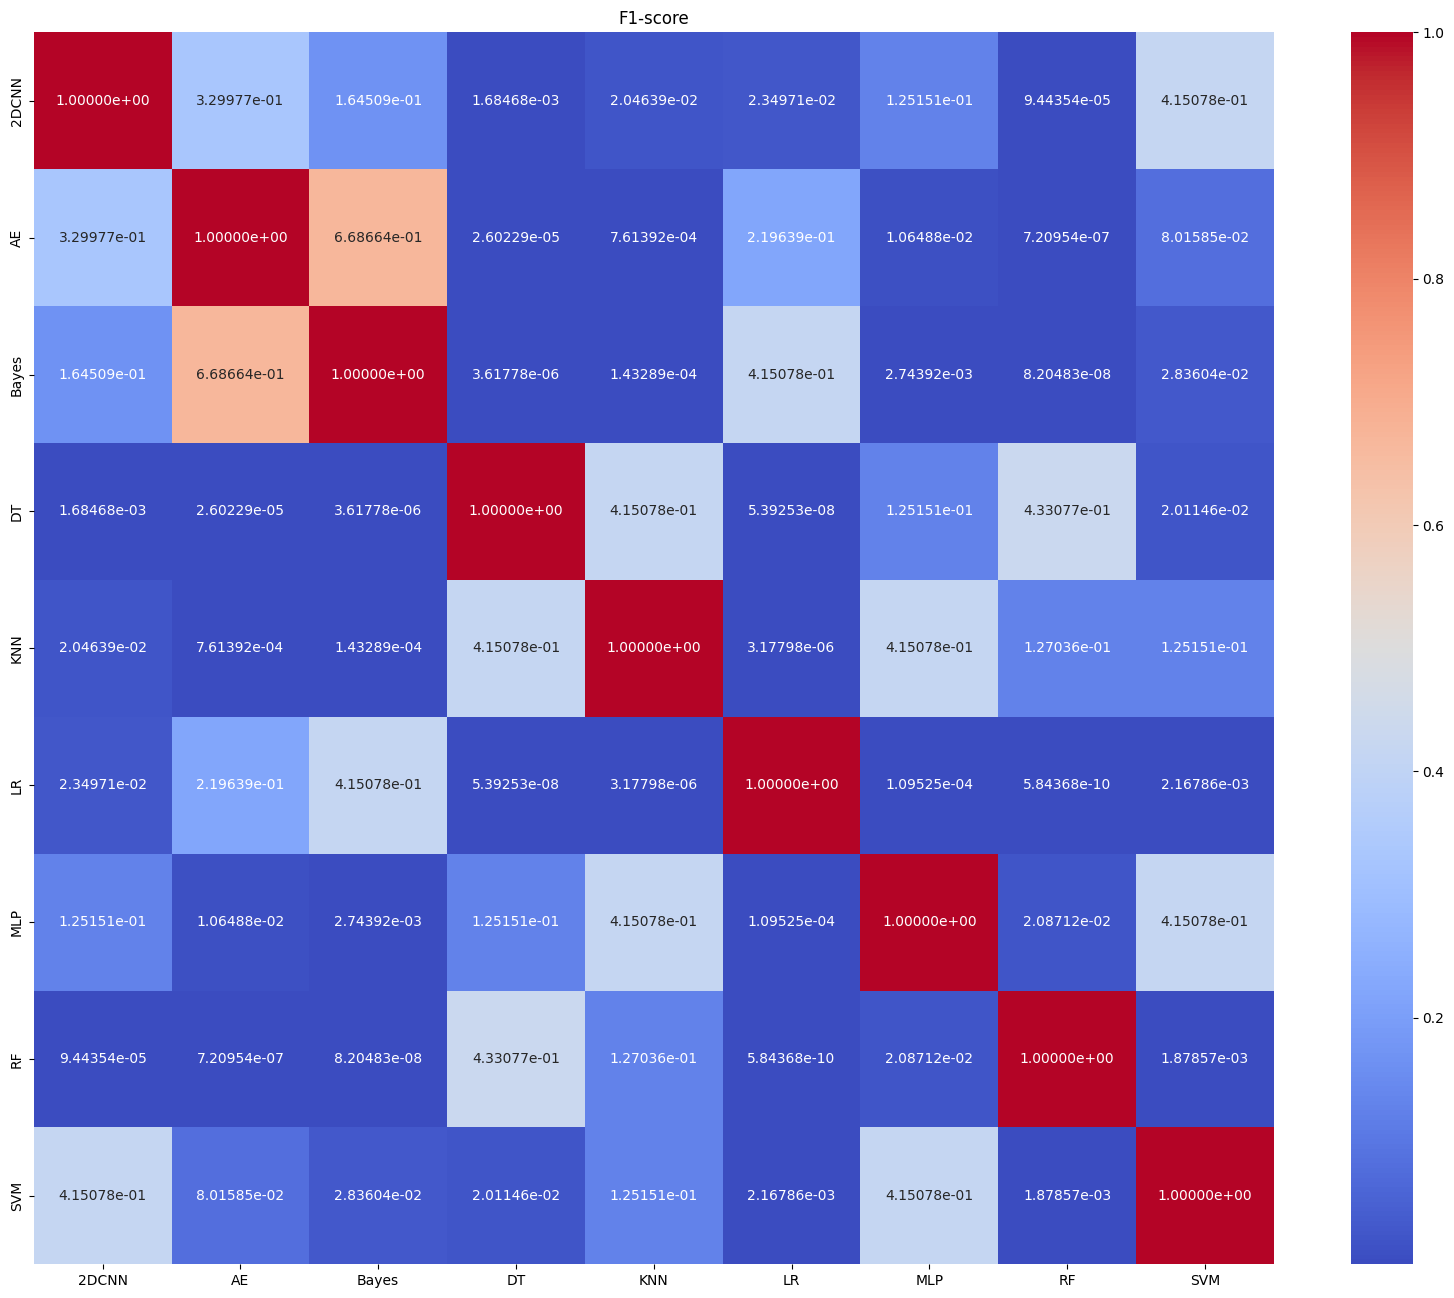

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o formato como notação científica
plt.figure(figsize=(20, 16))
sns.heatmap(posthoc_results, annot=True, fmt=".5e", cmap="coolwarm", cbar=True)  # .2e para notação científica
plt.title(f"{selected_metric}")

# Salvando a figura como um PDF
plt.savefig(f"{selected_metric}_heat_map.pdf", format="pdf")

# Mostrando o gráfico
plt.show()
